## U-Net for Image Segmentation
This notebook illustrates how to build a [UNet](https://arxiv.org/abs/1505.04597) for semantic image segmentation. This architecture is also a fully convolutional network. A key difference is the use of skip connections from the encoder to the decoder. You will see how this is implemented later as you build each part of the network.

At the end of this lab, you will be able to use the UNet to output segmentation masks that shows which pixels of an input image are part of the background, foreground, and outline. 

<img src='imgs/unet_result.png' alt='sample_output'>

# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

## Download the Oxford-IIIT Pets dataset
We will be training the model on the [Oxford Pets - IIT dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset. This contains pet images, their classes, segmentation masks and head region-of-interest. We will only use the images and segmentation masks in this lab.

This dataset is already included in TensorFlow Datasets and We can simply download it. The segmentation masks are included in versions 3 and above. The cell below will download the dataset and place the results in a dictionary named `dataset`. It will also collect information about the dataset and we'll assign it to a variable named `info`.

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\Ahmad Ansari\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shu

In [4]:
print(dataset.keys())

dict_keys(['train', 'test'])


## Prepare the Dataset
We will now prepare the train and test sets. The following utility functions preprocess the data. These include:

* simple augmentation by flipping the image
* normalizing the pixel values  
* resizing the images

Another preprocessing step is to adjust the segmentation mask's pixel values. The `README` in the [annotations](https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz) folder of the dataset mentions that the pixels in the segmentation mask are labeled as such:

| Label            | Class Name     |
| -------------    | -------------  |
| 1                | foreground     |
| 2                | background     |
| 3                | Not Classified |

<br>
<br>

For convenience, let's subtract `1` from these values and we will interpret these as `{'pet', 'background', 'outline'}`:

| Label            | Class Name     |
| -------------    | -------------  |
| 0                | pet            |
| 1                | background     |
| 2                | outline        |

In [5]:
def random_flip(input_image, input_mask):
    '''does a random flip of the image and mask'''
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

def normalize(input_image, input_mask):
    '''
    normalizes the input image pixel values to be from [0,1].
    subtracts 1 from the mask labels to have a range from [0,2]
    '''
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    '''resizes, normalizes, and flips the training data'''
    input_image = tf.image.resize(datapoint['image'], (128,128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128), method='nearest')
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    '''resizes and normalizes the test data'''
    input_image = tf.image.resize(datapoint['image'], (128,128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [6]:
# preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [7]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# group the test set into batches
test_dataset = test.batch(BATCH_SIZE)

Let's define a few more utilities to help us visualize our data and metrics.

In [8]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']

def display_with_metrics(display_list, iou_list, dice_score_list):
    '''displays a list of images/masks and overlays a list of IOU and Dice Scores'''
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list))]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True) # sorts in place
    display_string_list = ['{}: IOU:{} Dice Score:{}'.format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = '\n\n'.join(display_string_list)

    display(display_list, ['Image', 'Predicted Mask', 'True Mask'], display_string)

def display(display_list,titles=[], display_string=None):
    '''displays a list of images/masks'''
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)
    plt.show()
    
def show_image_from_dataset(dataset):
    '''displays the first image and its mask from a dataset'''
    
    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=["Image", "True Mask"])

def plot_metrics(metric_name, title, ylim=5):
    '''plots a given metric from the model history'''
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
    plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

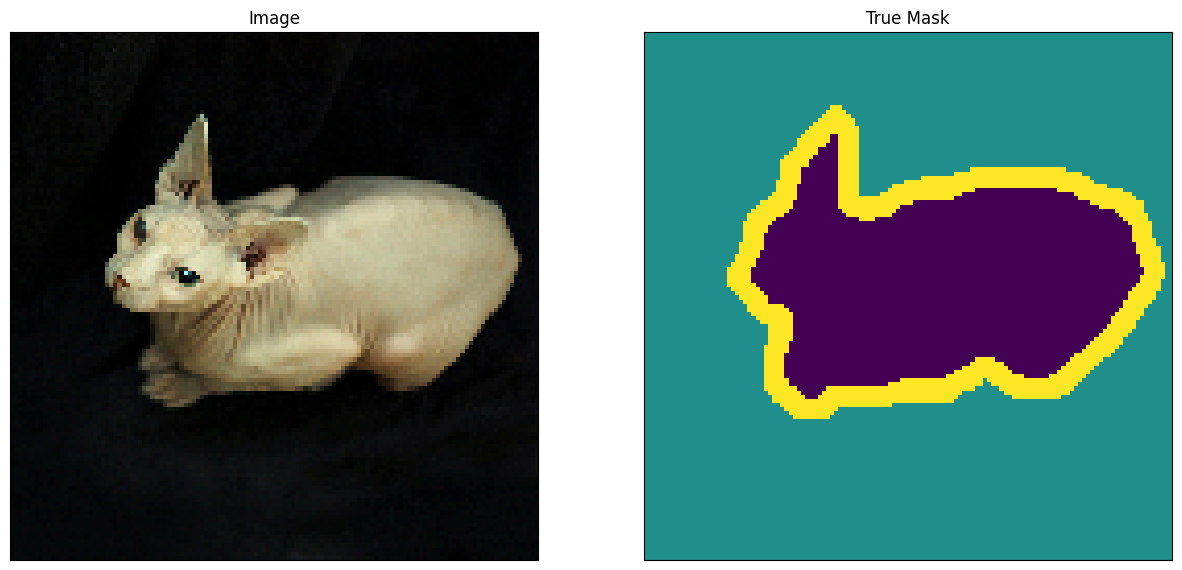

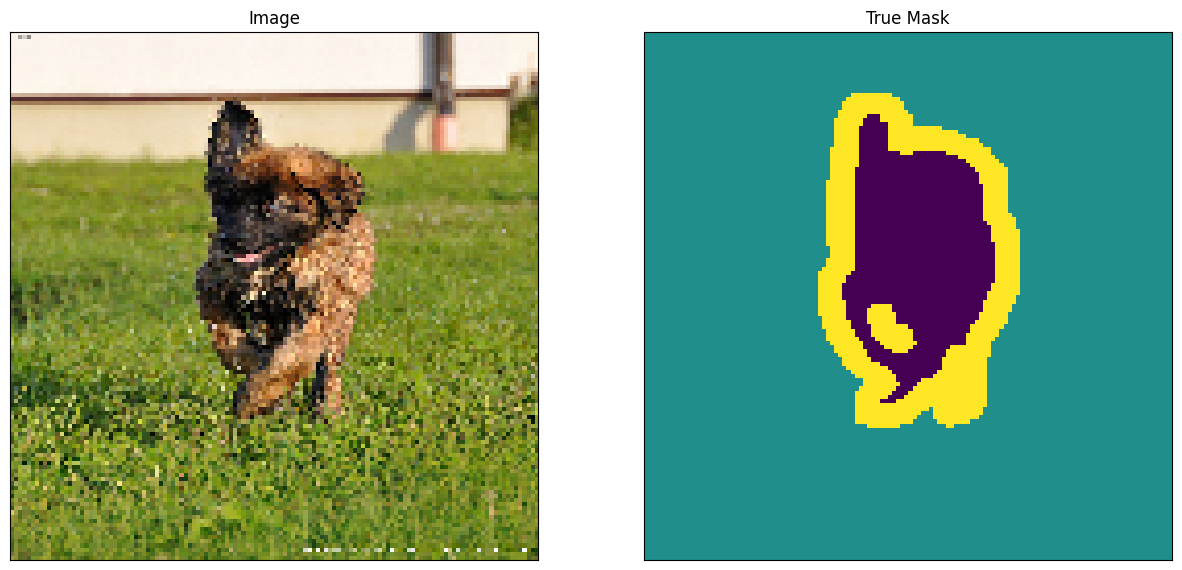

In [9]:
# display an image from the train set
show_image_from_dataset(train)

# display an image from the test set
show_image_from_dataset(test)

## Define the model

With the dataset prepared, we can now build the UNet. Here is the overall architecture:

<img src='imgs/unet_architecture.png' alt='unet'>

A UNet consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. The gray arrows correspond to the skip connections that concatenate encoder block outputs to each stage of the decoder. Let's see how to implement these starting with the encoder.

## Encoder
<img src='imgs/encoder_unet.png' alt='unet'>

In [10]:
def conv2d_block(input_tensor, n_filters, kernal_size=3):
    '''
    Adds 2 convolutional layers with the parameters passed to it
    
    Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution
    
    Returns:b
    tensor of output features
    '''
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(kernal_size, kernal_size), kernel_initializer='he_normal', padding='same')(x)
        x = tf.keras.layers.Activation('relu')(x)

    return x

def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
    '''
    Adds two convolutional blocks and then perform down sampling on output of convolutions.
    
    Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    pool_size (int, int) -- size of the pooling layer
    dropout (float) -- between 0 and 1. rate of the dropout layer
    
    Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
    '''
    f = conv2d_block(input_tensor=inputs, n_filters=n_filters)
    p = tf.keras.layers.MaxPool2D(pool_size=pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)

    return f, p

def encoder(inputs):
    '''
    This function defines the encoder or downsampling path.
    
    Args:
    inputs (tensor) -- batch of input images
    
    Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
    '''
    f1, p1 = encoder_block(inputs=inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
    f2, p2 = encoder_block(inputs=p1, n_filters=128, pool_size=(2,2), dropout=0.3)
    f3, p3 = encoder_block(inputs=p2, n_filters=256, pool_size=(2,2), dropout=0.3)
    f4, p4 = encoder_block(inputs=p3, n_filters=512, pool_size=(2,2), dropout=0.3)

    return p4, (f1, f2, f3, f4)

def bottleneck(inputs):
    '''
    This function defines the bottleneck convolutions to extract more features before the upsampling layers.
    '''
    bottleneck = conv2d_block(input_tensor=inputs, n_filters=1024)

    return bottleneck

### Decoder

Finally, we have the decoder which upsamples the features back to the original image size.
At each upsampling level, we will take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block. This is summarized in the figure below.

<img src='imgs/decoder_unet.png' alt='unet_decoder'>

In [11]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    '''
    defines the one decoder block of the UNet
    
    Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    dropout (float) -- between 0 and 1. rate of the dropout layer
    
    Returns:
    c (tensor) -- output features of the decoder block
    '''
    u = tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    c = tf.keras.layers.Concatenate()([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(input_tensor=c, n_filters=n_filters)

    return c

def decoder(inputs, convs, output_channels):
    '''
    Defines the decoder of the UNet chaining together 4 decoder blocks. 
    
    Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map
    
    Returns:
    outputs (tensor) -- the pixel wise label map of the image
    ''' 
    f1, f2, f3, f4 = convs
    c6 = decoder_block(inputs=inputs, conv_output=f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(inputs=c6, conv_output=f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(inputs=c7, conv_output=f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(inputs=c8, conv_output=f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    output = tf.keras.layers.Conv2D(output_channels, kernel_size=(1,1), activation='softmax')(c9)

    return output

## Putting it all together(Final Unet Model)

In [12]:
OUTPUT_CHANNELS = 3

def UNET():
    '''
    Defines the UNet by connecting the encoder, bottleneck and decoder.
    '''
    inputs = tf.keras.layers.Input(shape=(128,128,3,))
    encoder_output, convs = encoder(inputs=inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs=convs, output_channels=OUTPUT_CHANNELS)
    model = tf.keras.Model(inputs, outputs)
    
    return model

model = UNET()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 128, 128, 64)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 128, 128, 64)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 64)        │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64, 64, 64)        │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 64, 64, 128)       │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 128)       │         147,584 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 64, 64, 128)       │               0 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 128)       │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 32, 32, 128)       │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 256)       │         295,168 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_4 (Activation)     │ (None, 32, 32, 256)       │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 256)       │         590,080 │ activation_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_5 (Activation)     │ (None, 32, 32, 256)       │               

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the model

In [13]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# configure the training parameters and train the model

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 2
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# this will take around 20 minutes to run
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/2
57/57 ━━━━━━━━━━━━━━━━━━━━ 1071s 19s/step - accuracy: 0.6972 - loss: 0.7228 - val_accuracy: 0.6721 - val_loss: 0.7588
Epoch 2/2
57/57 ━━━━━━━━━━━━━━━━━━━━ 1061s 19s/step - accuracy: 0.7389 - loss: 0.6426 - val_accuracy: 0.7713 - val_loss: 0.5709


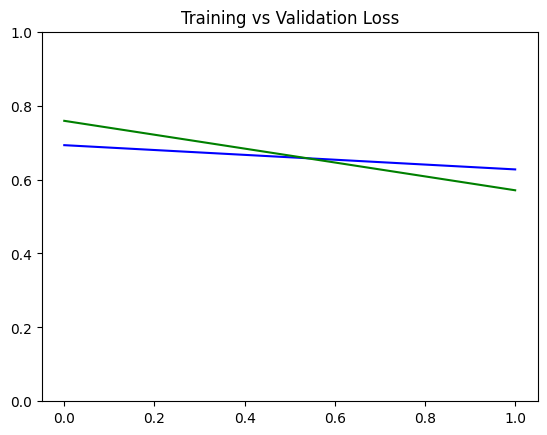

In [17]:
# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

## Make predictions

In [19]:
# Prediction Utilities

def get_test_image_and_annotation_arrays():
    '''
    Unpacks the test dataset and returns the input images and segmentation masks
    '''
    
    ds = test_dataset.unbatch()
    ds = ds.batch(info.splits['test'].num_examples)
    
    images = []
    y_true_segments = []
    
    for image, annotation in ds.take(1):
        y_true_segments = annotation.numpy()
        images = image.numpy()
    
    y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
    
    return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
    '''
    Creates the segmentation mask by getting the channel with the highest probability. Remember that we
    have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
    highest probability.
    '''
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
    '''
    Feeds an image to a model and returns the predicted mask.
    '''
    
    image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    return pred_mask 

## Compute class wise metrics

In [20]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):
    
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [21]:
# Setup the ground truth and predictions.

# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

57/57 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step


In [23]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [24]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou)) 

pet         0.5716306647492135 
background  0.7504453419867813 
outline     0.1620240989013941 


In [25]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 


pet         0.727436385113518 
background  0.8574336187328424 
outline     0.27886529901529494 


## Show Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


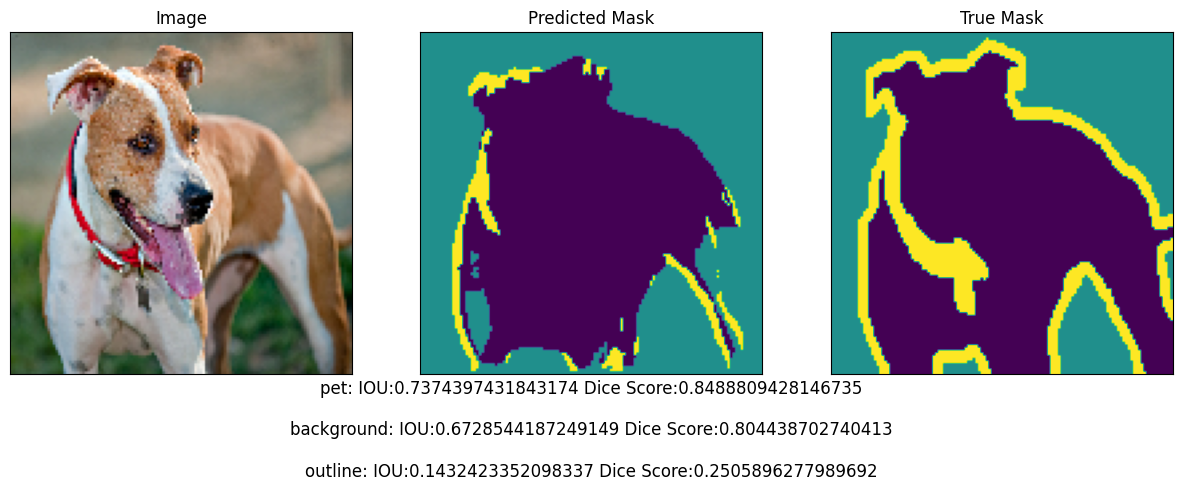

In [26]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 3646

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

**That's all for this Project! In this Project i have trained the model just for 2 epochs. However, training it on collab for 10 epochs gives you a satasfactory results, as mentioned in the start of notebook!**